In [1]:
!pip install flax

     |████████████████████████████████| 184 kB 5.3 MB/s 
     |████████████████████████████████| 136 kB 32.6 MB/s 
     |████████████████████████████████| 72 kB 588 kB/s 


In [12]:
import numpy as np

from collections import deque
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

# To measure the time it takes to train a network
import time

# Everything we need from JAX
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp # Computes the log of the sum of exponentials of input elements.
from jax.experimental import optimizers

# Flax module for deep learning models
import flax.linen as nn

# The key for our random number generator, we need this because JAX will distribute the calculation
key = random.PRNGKey(0)

### The Wolff cluster update algorithm for the Ising model

In [13]:
class WolffMonteCarlo:
    """ Wolff Monte Carlo simulator for the Ising model."""
    def __init__(self, L, T, method=None):
        self._L = L
        self._T = T
        self._K = 2. / T
        self._method = method

        # set up initial state
        self._state = np.random.randint(0, 2, size=[L, L])

    @property
    def L(self):
        return self._L

    @property
    def T(self):
        return self._T

    @property
    def K(self):
        return self._K

    @property
    def state(self):
        return self._state

    def probability_add_bond(self, x1, y1, x2, y2, state):
        """The probability for adding a bond."""
        E = 1.0 if state[x1, y1] == state[x2, y2] else 0.0
        return 1.0 - np.exp(-self.K * E)

    def set_T(self, T):
        self._T = T
        self._K = 2. / T

    def wolff_iterative(self, state):
        """ Iterative Wolff Algorithm 
            This algorithm uses a doubly ended queue (deque), which provides O(1) 
            operations for adding and removing items from both ends of a list. 
        """
        
        # Convenient lists for indexing
        # Below, we'll use these to get the left (or 'above', etc) neighbors of a site.
        # Includes periodic boundaries! Another option would be to replace
        #    left[x1]   by   (x1 - 1) % L
        # but that does an addition and a module every step.
        left = [self.L - 1] + list(range(self.L - 1))
        right = list(range(1, self.L)) + [0]
        
        # Book-keeping containers
        sites_to_consider = deque()
        sites_to_flip = set()
        bonds_considered = set()

        # Initial queue of sites to consider, just consisting of a single (x,y) location
        sites_to_consider.append((
            np.random.randint(0, self.L),
            np.random.randint(0, self.L)
        ))

        # As long as there are sites to consider
        while sites_to_consider:
            # Pick a new site to consider from the queue, either using
            # breadth first or depth first
            if self._method == "BFS":
                x1, y1 = sites_to_consider.popleft()
            if self._method == "DFS":
                x1, y1 = sites_to_consider.pop()

            # For the neighbors of this site
            for x2, y2 in zip([left[x1], right[x1], x1, x1],
                              [y1, y1, left[y1], right[y1]]):
                
                # Check if we have not already considered this pair
                if not (x1, y1, x2, y2) in bonds_considered:
                    # Add the pair so that we don't flip it twice
                    bonds_considered.add((x1, y1, x2, y2))
                    bonds_considered.add((x2, y2, x1, y1))

                    if np.random.rand() < self.probability_add_bond(x1, y1, x2, y2, state):
                        sites_to_consider.append((x2, y2))
                        sites_to_flip.add((x1, y1))
                        sites_to_flip.add((x2, y2))
                        
        return sites_to_flip

    def step(self):
        """Use Wolff and perform update."""

        # Get a list of sites to flip...
        to_flip = self.wolff_iterative(self._state)

        # ...and flip them
        for (x, y) in to_flip:
            self._state[x, y] = 1 - self._state[x, y]

        # Return the list of the flipped sites
        return to_flip


In [14]:
def generate_Ising_configurations(L, numSamplesPerT, Ts, equilibrationSteps=100):
    ''' Generates snapshots for the 2D Ising model for a given set of temperatures

    Samples are generated using Wolff cluster updates.

    Parameters:

        * `L`: Linear size of the system
        * `numSamplesPerT`: Number of samples to generate per temperature
        * `Ts`: List of temperatures
        * `equilibrationSteps`: Number of equilibration steps

    Returns:
        * A dictionary with the sampled configurations for each temperature

    '''

    # Initialize a new simulator
    sim = WolffMonteCarlo(L=L, T=5, method="DFS")

    all_data = {}

    # Loop over a fixed set of temperatures
    for T in Ts:
        print("Generating samples for L = %d at T = %.3f"%(L,T))

        # Set temperature
        sim.set_T(T)

        # For storing all of the configurations
        snapshots = []
        for s in range(numSamplesPerT + equilibrationSteps):

            # Keep flipping sites, until we flipped at least L^2 of them
            c = 0
            while c < 1:
                to_flip = sim.step()
                c = c + len(to_flip) / L / L

            # The first half of the flips are to equilibrate, the rest are samples
            if s >= equilibrationSteps:
                snapshots.append(np.array(-1 + 2 * sim.state.reshape(-1)))


        all_data['%.3f'%(T)] = np.array(snapshots)

    return all_data

## Generate Ising model data

In [15]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.6, 3.0, 0.25) #np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = {}
for L in [10, 20, 40]:#, 80]:
    all_data[L] = generate_Ising_configurations(L, 100, Ts) # Returns half the number of samples asked for

Generating samples for L = 10 at T = 1.600
Generating samples for L = 10 at T = 1.850
Generating samples for L = 10 at T = 2.100
Generating samples for L = 10 at T = 2.350
Generating samples for L = 10 at T = 2.600
Generating samples for L = 10 at T = 2.850
Generating samples for L = 20 at T = 1.600
Generating samples for L = 20 at T = 1.850
Generating samples for L = 20 at T = 2.100
Generating samples for L = 20 at T = 2.350
Generating samples for L = 20 at T = 2.600
Generating samples for L = 20 at T = 2.850
Generating samples for L = 40 at T = 1.600
Generating samples for L = 40 at T = 1.850
Generating samples for L = 40 at T = 2.100
Generating samples for L = 40 at T = 2.350
Generating samples for L = 40 at T = 2.600
Generating samples for L = 40 at T = 2.850


## Zipping the Ising model

In [18]:
import gzip
import shutil

sizes = {}
for L in [10, 20, 40]:#, 80]:
    sizes[L] = []

    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        out = gzip.compress(data)
        sizes[L].append(out.__sizeof__())

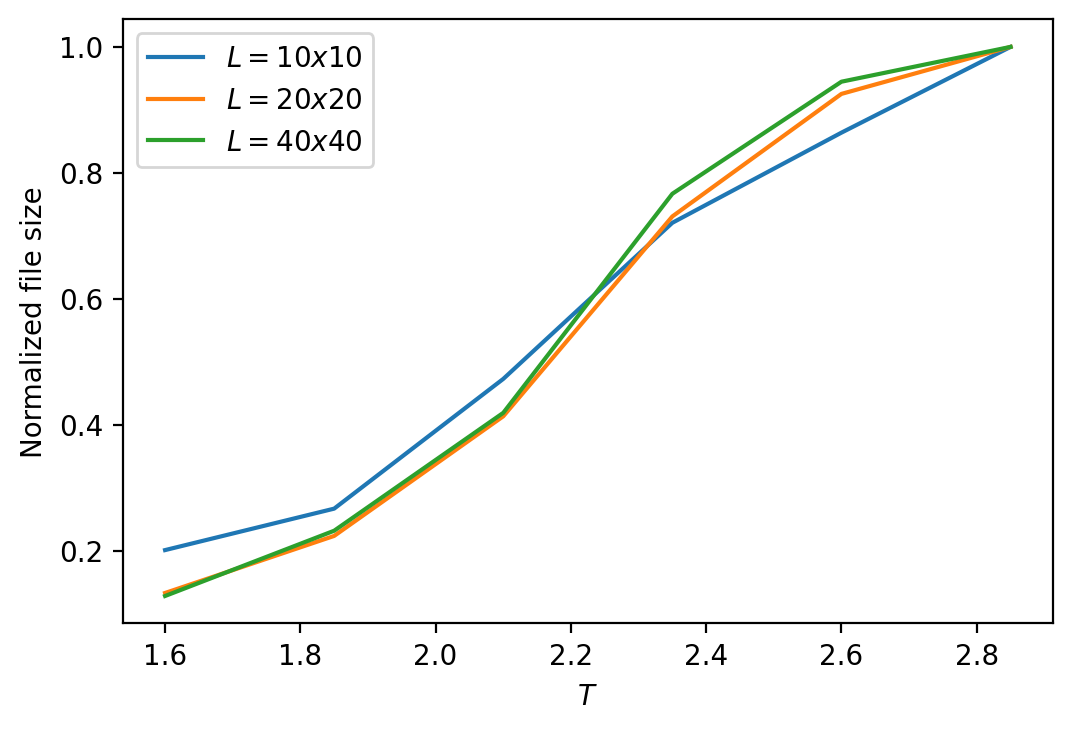

In [19]:
fig, ax = plt.subplots(dpi=200)
for L in [10, 20, 40]:#, 80]:
    ax.plot(Ts, sizes[L]/np.max(sizes[L]), label='$L=%dx%d$'%(L,L))
    
ax.set_xlabel("$T$")
ax.set_ylabel("Normalized file size")
ax.legend(fancybox=True)

### Challenges and ideas
* Add system size 80, add more samples
* Try a scaling collapse to extract T_c

## K-means'ing the Ising model

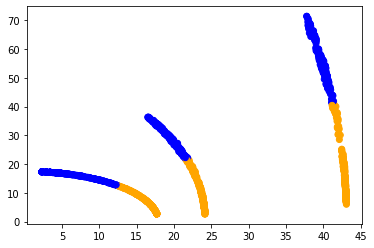

In [ ]:
from sklearn.cluster import KMeans

for a,L in enumerate([10,20,40]):
    
    # Collect all data (for all Ts) into one list
    raw_x = []
    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        for c,snapshot in enumerate(data):
            raw_x.append( snapshot )
            
    kmeans = KMeans(n_clusters=2, random_state=0).fit(raw_x)
    proj = kmeans.transform(raw_x)
    colors = ['blue' if l == 0 else 'orange' for l in kmeans.labels_]
    plt.scatter(proj[:,0], proj[:,1], color=colors)

### Challenge idea

Find the index of data where the label changes from blue to orange, and see which T that corresponds to. How does that T correlate with the true transition temperature?

## PCA'ing the Ising model
The original: https://arxiv.org/abs/1606.00318

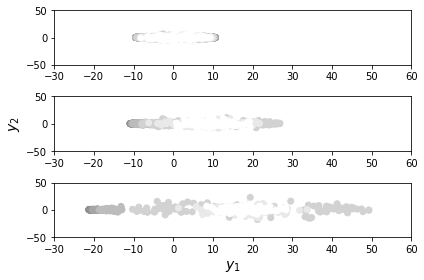

In [ ]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(3,1)
principal_vectors = [] 
for a,L in enumerate([10,20,40]):
    raw_x = []
    colors = [] 
   
    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        for c,snapshot in enumerate(data):
            raw_x.append( snapshot )
            colors.append( np.array([1, 1, 1]) * T/np.max(Ts) ) 

    pca = PCA(n_components=2)
    pca.fit(raw_x)
    proj = pca.transform(raw_x)
    principal_vectors.append( pca.components_[0] )
    ax[a].scatter(proj[:,0], proj[:,1], color=colors)
    
    ax[a].set_xlim([-30,60])
    ax[a].set_ylim([-50,50])
    
ax[1].set_ylabel("$y_2$", fontsize=14)
ax[2].set_xlabel("$y_1$", fontsize=14)
fig.tight_layout()

Text(0, 0.5, 'First principal component vector')

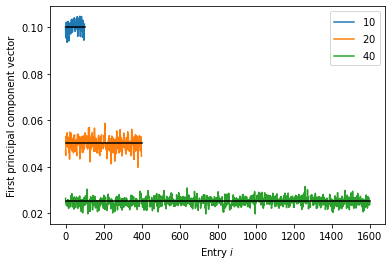

In [ ]:
fig, ax = plt.subplots()

for a,L in enumerate([10,20,40]):
    ax.plot(np.abs(principal_vectors[a]), label="$%d$"%L)
    ax.plot([0, L**2], [1/L, 1/L], c='k')
    
ax.legend(fancybox=True)
ax.set_xlabel("Entry $i$")
ax.set_ylabel("First principal component vector")

## AE-ing the Ising model

## VAE-ing the Ising model
Be sure to check out https://arxiv.org/abs/1703.02435

The example below will not fully reproduce those results, simply because the network is small, training is short, not enough data, etc... Play around with it, and you should be able to reproduce it fairly straightforwardly!

In [83]:
data = []
test_data = []
temperatures = []
for T in Ts:
    for i,snapshot in enumerate(all_data[40]['%.3f'%T]):        
        if i < 90:
            data.append(snapshot)
        else: 
            test_data.append(snapshot)
            temperatures.append(T)
    
data = np.array(data)
test_data = np.array(test_data)
print(data.shape)
print(test_data.shape)

(540, 1600)
(60, 1600)


In [85]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import optim
from jax import grad, jit, vmap, value_and_grad
from jax import random

class Encoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(32, name='fc1')(x)
        x = nn.relu(x)
        
        # Separate layer for the mean
        mean_x = nn.Dense(self.latent_dim, name='fc2_mean')(x)
        
        # We treat this as the logarithm of the variance, because this can be a small number
        logvar_x = nn.Dense(self.latent_dim, name='fc2_logvar')(x)
        
        return mean_x, logvar_x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(32, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(data.shape[1], name='fc2')(z)
        z = nn.tanh(z)
        return z

In [86]:
class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar
    
    def generate(self, z):
        return self.decoder(z)

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

In [87]:
@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

dim = int(np.sqrt(data.shape[1]))
@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        
        comparison = jnp.concatenate([images[:8].reshape(-1, dim,dim, 1),
                                      recon_images[:8].reshape(-1, dim,dim, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, dim,dim, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, vae)({'params': params})

@jax.jit
def train_step(optimizer, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = vae.apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss, recon_x

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    _, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

### Train it!

In [97]:
batch_size = 32
init_data = jnp.ones((batch_size, data.shape[1]), jnp.float32)

latent_dim = 1
vae = VAE(latent_dim = latent_dim)
params = vae.init(key, init_data, key)['params']

optimizer = optim.Adam(learning_rate=1e-4).create(params)
optimizer = jax.device_put(optimizer)

rng, z_key, eval_rng = random.split(key, 3)
z = random.normal(z_key, (64, latent_dim))

# Divide into batches
num_batches = len(data) // batch_size

# Loop over the training epochs
num_epochs = 200
for epoch in range(num_epochs):

    # Shuffle data
    indices = np.random.permutation(len(data))
    batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

    for b in range(len(batch_indices)):
        batch = jnp.array([data[i] for i in batch_indices[b]])
        rng, key = random.split(rng)
        optimizer = train_step(optimizer, batch, key)
        
    metrics, comparison, sample = eval(optimizer.target, test_data, z, eval_rng)

    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
        epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
    ))

/usr/local/lib/python3.7/dist-packages/flax/optim/base.py:52: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  'for detailed instructions.', DeprecationWarning)


eval epoch: 1, loss: 1114.3101, BCE: 1113.6991, KLD: 0.6109
eval epoch: 2, loss: 1074.8918, BCE: 1073.9147, KLD: 0.9772
eval epoch: 3, loss: 1018.3484, BCE: 1016.6678, KLD: 1.6807
eval epoch: 4, loss: 950.1708, BCE: 947.6212, KLD: 2.5497
eval epoch: 5, loss: 875.9982, BCE: 871.9046, KLD: 4.0936
eval epoch: 6, loss: 797.7819, BCE: 791.2892, KLD: 6.4926
eval epoch: 7, loss: 716.4336, BCE: 705.2727, KLD: 11.1609
eval epoch: 8, loss: 635.5369, BCE: 619.1195, KLD: 16.4174
eval epoch: 9, loss: 562.0265, BCE: 541.2275, KLD: 20.7989
eval epoch: 10, loss: 500.3798, BCE: 476.6400, KLD: 23.7398
eval epoch: 11, loss: 447.8725, BCE: 422.3108, KLD: 25.5617
eval epoch: 12, loss: 407.2293, BCE: 380.7029, KLD: 26.5264
eval epoch: 13, loss: 374.7300, BCE: 349.6825, KLD: 25.0475
eval epoch: 14, loss: 342.4308, BCE: 318.6870, KLD: 23.7438
eval epoch: 15, loss: 312.0283, BCE: 288.5457, KLD: 23.4827
eval epoch: 16, loss: 281.8954, BCE: 260.1273, KLD: 21.7680
eval epoch: 17, loss: 249.6469, BCE: 227.4699, KL

Text(0, 0.5, 'Latent variable $\\mu$')

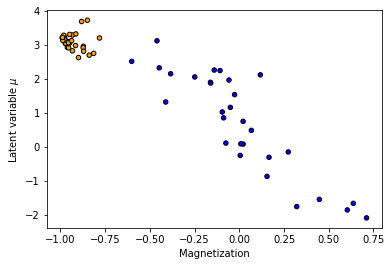

In [98]:
recon_x, mean, logvar = vae.apply({'params': optimizer.target}, test_data, z_key)
magnetization = np.mean(test_data, axis=1)
colors = ['orange' if t < 2.27 else 'blue' for t in temperatures]

fig, ax = plt.subplots()
ax.scatter( magnetization, mean, c=colors, edgecolors='k', s = 20 )
ax.set_xlabel("Magnetization")
ax.set_ylabel("Latent variable $\mu$")

In [101]:
mean_vs_T = []
magnetization_vs_T = []
for T in Ts:
    # Get all samples at this T
    samples_at_T = all_data[40]['%.3f'%T]
    # Get the mean for all of these
    recon_x, mean, logvar = vae.apply({'params': optimizer.target}, samples_at_T, z_key)
    
    mean_vs_T.append( np.mean(mean) )
    magnetization_vs_T.append( np.mean([ np.mean(t) for t in samples_at_T ]) )

Text(0, 0.5, 'Magnetization')

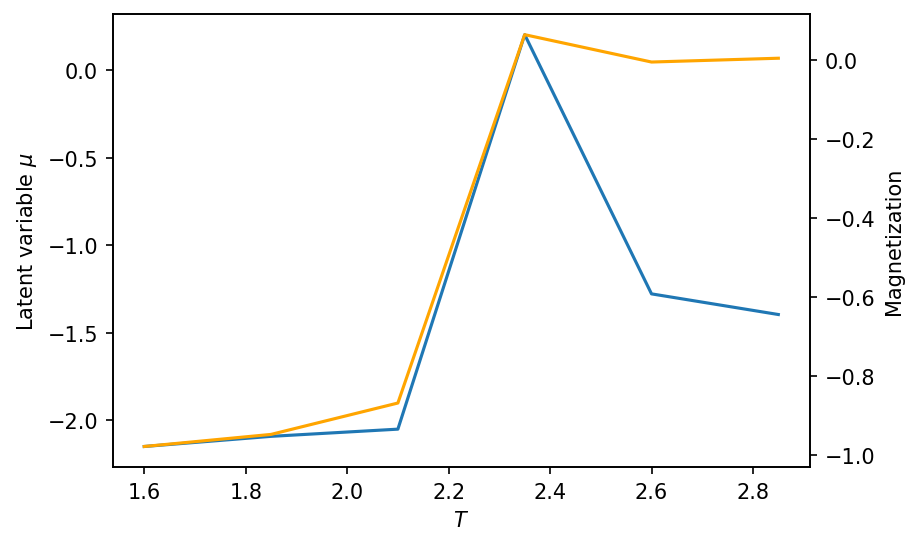

In [102]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ts, 1-np.array(mean_vs_T))

ax2 = ax.twinx()
ax2.plot(Ts, magnetization_vs_T, c='orange')

ax.set_xlabel("$T$")
ax.set_ylabel("Latent variable $\mu$")
ax2.set_ylabel("Magnetization")

# Having fun with VAEs and MNIST

In [3]:
import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np

_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
    """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA):
        os.makedirs(_DATA)
    out_file = path.join(_DATA, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.)
    test_images = _partial_flatten(test_images) / np.float32(255.)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    if permute_train:
        perm = np.random.RandomState(0).permutation(train_images.shape[0])
        train_images = train_images[perm]
        train_labels = train_labels[perm]

    return train_images, train_labels, test_images, test_labels

In [4]:
train_images, _, test_images, _ = mnist(permute_train=True)

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/jax_example_data/


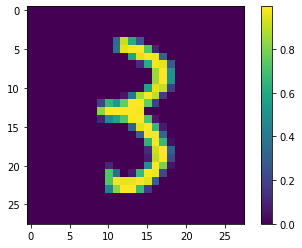

In [5]:
plt.imshow( np.reshape(train_images[0], (28,28)) )
plt.colorbar()

In [6]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import optim
from jax import grad, jit, vmap, value_and_grad
from jax import random

class Encoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128, name='fc1')(x)
        x = nn.relu(x)
        
        # Separate layer for the mean
        mean_x = nn.Dense(self.latent_dim, name='fc2_mean')(x)
        
        # We treat this as the logarithm of the variance, because this can be a small number
        logvar_x = nn.Dense(self.latent_dim, name='fc2_logvar')(x)
        
        return mean_x, logvar_x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(128, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(784, name='fc2')(z)
        z = nn.tanh(z)
        return z
    
class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar
    
    def generate(self, z):
        return self.decoder(z)

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        
        comparison = jnp.concatenate([images[:8].reshape(-1, 28,28, 1),
                                      recon_images[:8].reshape(-1, 28,28, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 28,28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, vae)({'params': params})

@jax.jit
def train_step(optimizer, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = vae.apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss, recon_x

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    _, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [7]:
batch_size = 32
init_data = jnp.ones((batch_size, train_images.shape[1]), jnp.float32)

latent_dim = 10
vae = VAE(latent_dim = latent_dim)
params = vae.init(key, init_data, key)['params']

optimizer = optim.Adam(learning_rate=1e-4).create(params)
optimizer = jax.device_put(optimizer)

rng, z_key, eval_rng = random.split(key, 3)
z = random.normal(z_key, (64, latent_dim))

# Divide into batches
num_batches = len(train_images) // batch_size

# Loop over the training epochs
num_epochs=50
for epoch in range(num_epochs):

    # Shuffle data
    indices = np.random.permutation(len(train_images))
    batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

    for b in range(len(batch_indices)):
        batch = jnp.array([train_images[i] for i in batch_indices[b]])
        rng, key = random.split(rng)
        optimizer = train_step(optimizer, batch, key)
        
    metrics, comparison, sample = eval(optimizer.target, test_images, z, eval_rng)

    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
        epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
    ))

/usr/local/lib/python3.7/dist-packages/flax/optim/base.py:52: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  'for detailed instructions.', DeprecationWarning)


eval epoch: 1, loss: 532.2519, BCE: 531.2943, KLD: 0.9576
eval epoch: 2, loss: 494.2753, BCE: 489.8940, KLD: 4.3813
eval epoch: 3, loss: 449.1041, BCE: 437.1346, KLD: 11.9695
eval epoch: 4, loss: 412.3895, BCE: 394.8261, KLD: 17.5634
eval epoch: 5, loss: 391.2339, BCE: 372.9982, KLD: 18.2357
eval epoch: 6, loss: 379.7444, BCE: 362.8208, KLD: 16.9236
eval epoch: 7, loss: 371.7266, BCE: 356.3651, KLD: 15.3616
eval epoch: 8, loss: 365.2642, BCE: 350.7989, KLD: 14.4653
eval epoch: 9, loss: 360.0806, BCE: 346.1144, KLD: 13.9662
eval epoch: 10, loss: 356.4803, BCE: 343.1254, KLD: 13.3548
eval epoch: 11, loss: 353.5554, BCE: 340.6491, KLD: 12.9063
eval epoch: 12, loss: 350.9828, BCE: 338.4911, KLD: 12.4916
eval epoch: 13, loss: 348.6940, BCE: 336.4532, KLD: 12.2408
eval epoch: 14, loss: 346.7061, BCE: 334.6196, KLD: 12.0865
eval epoch: 15, loss: 344.9268, BCE: 333.1571, KLD: 11.7697
eval epoch: 16, loss: 343.3175, BCE: 331.8138, KLD: 11.5037
eval epoch: 17, loss: 341.8207, BCE: 330.4873, KLD:

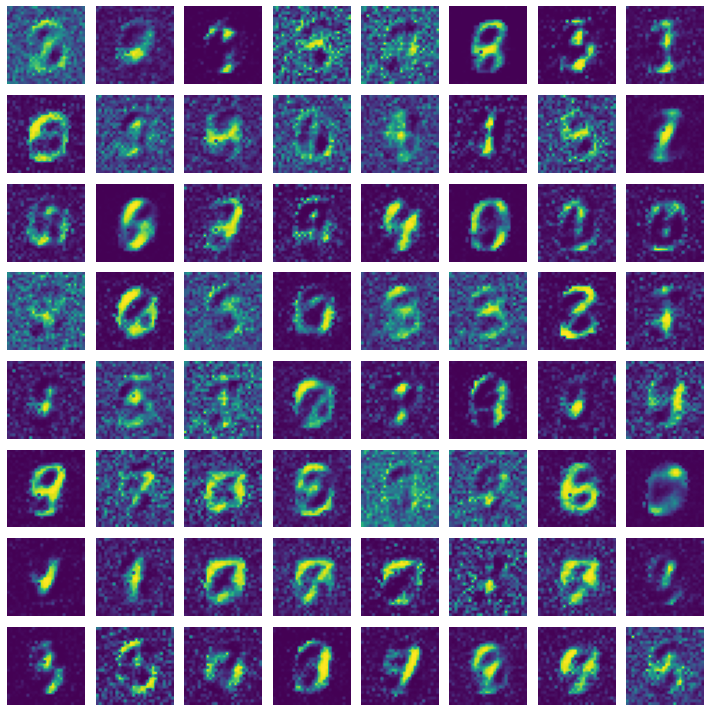

In [11]:
z = random.normal(z_key, (64, latent_dim))
def generate_samples(vae):
    generate_images = vae.generate(z)
    generate_images = generate_images.reshape(-1, 28, 28, 1)
    return generate_images

imgs = nn.apply(generate_samples, vae)({'params': optimizer.target})
fig, ax = plt.subplots(8,8, figsize=(10,10))
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(imgs[i*8 + j, :, :, 0])
        ax[i,j].axis('off')
fig.tight_layout()